In [ ]:
pip install pgmpy

In [38]:
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import ToTensor
from torch.optim import RMSprop
from torch.optim import Adam as tAdam

This section is adopted from pgmpy tutorial notebooks. Visit [this link](https://pgmpy.org/detailed_notebooks/2.%20Bayesian%20Networks.html).
# Bayesian network
A Bayesian network is a probabilistic graphical model (a type of statistical model) that represents a set of variables and their conditional dependencies via a directed acyclic graph (DAG). Bayesian networks are ideal for taking an event that occurred and predicting the likelihood that any one of several possible known causes was the contributing factor. 

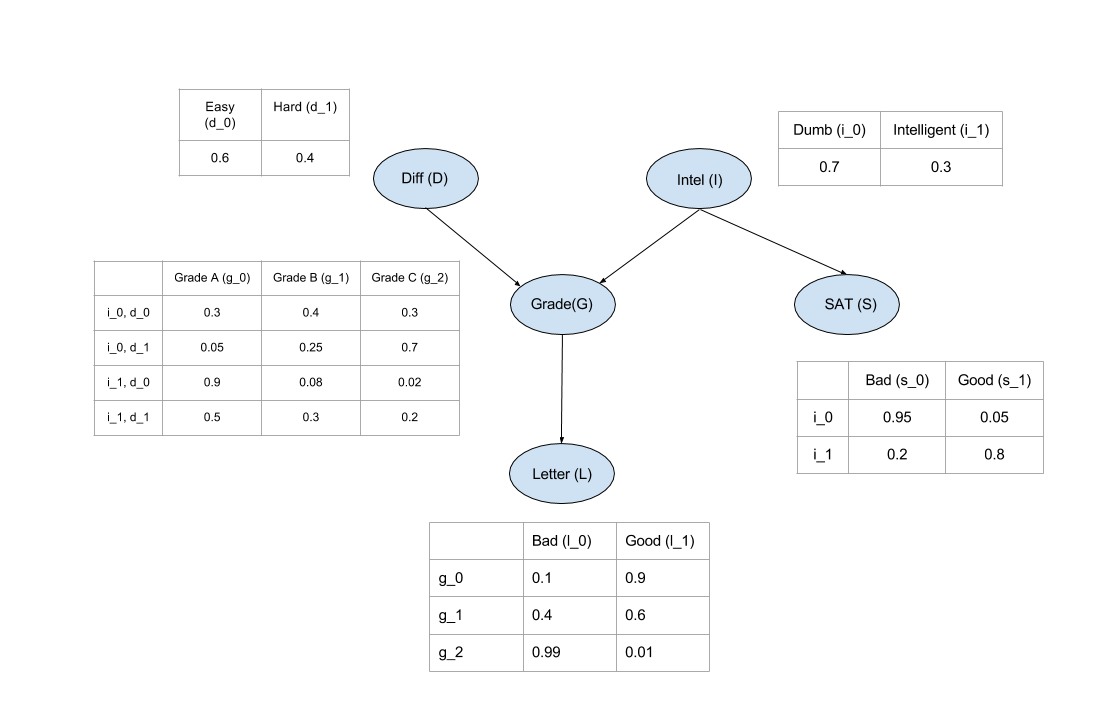

In the following, A bayesian network is defined and corresponding conditional probabilities have been assigned.

In [39]:
model = BayesianModel([('D', 'G'), ('I', 'G'), ('G', 'L'), ('I', 'S')])

cpd_d = TabularCPD(variable='D', variable_card=2, values=[[0.6], [0.4]], state_names={'D': ['Easy', 'Hard']})
cpd_i = TabularCPD(variable='I', variable_card=2, values=[[0.7], [0.3]], state_names={'I': ['Dumb', 'Intelligent']})
cpd_g = TabularCPD(variable='G', variable_card=3,
                      values=[[0.3, 0.05, 0.9,  0.5],
                              [0.4, 0.25, 0.08, 0.3],
                              [0.3, 0.7,  0.02, 0.2]],
                      evidence=['I', 'D'],
                      evidence_card=[2, 2],
                      state_names={'G': ['A', 'B', 'C'],
                                   'I': ['Dumb', 'Intelligent'],
                                   'D': ['Easy', 'Hard']})

cpd_l = TabularCPD(variable='L', variable_card=2,
                      values=[[0.1, 0.4, 0.99],
                              [0.9, 0.6, 0.01]],
                      evidence=['G'],
                      evidence_card=[3],
                      state_names={'L': ['Bad', 'Good'],
                                   'G': ['A', 'B', 'C']})

cpd_s = TabularCPD(variable='S', variable_card=2,
                      values=[[0.95, 0.2],
                              [0.05, 0.8]],
                      evidence=['I'],
                      evidence_card=[2],
                      state_names={'S': ['Bad', 'Good'],
                                   'I': ['Dumb', 'Intelligent']})


model.add_cpds(cpd_d, cpd_i, cpd_g, cpd_l, cpd_s)
model.check_model()

/opt/anaconda3/lib/python3.7/site-packages/pgmpy/models/BayesianModel.py:10: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  FutureWarning,


True

Printing CPDs:

In [40]:
for cpd in model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)

CPD of D:
+---------+-----+
| D(Easy) | 0.6 |
+---------+-----+
| D(Hard) | 0.4 |
+---------+-----+
CPD of I:
+----------------+-----+
| I(Dumb)        | 0.7 |
+----------------+-----+
| I(Intelligent) | 0.3 |
+----------------+-----+
CPD of G:
+------+---------+---------+----------------+----------------+
| I    | I(Dumb) | I(Dumb) | I(Intelligent) | I(Intelligent) |
+------+---------+---------+----------------+----------------+
| D    | D(Easy) | D(Hard) | D(Easy)        | D(Hard)        |
+------+---------+---------+----------------+----------------+
| G(A) | 0.3     | 0.05    | 0.9            | 0.5            |
+------+---------+---------+----------------+----------------+
| G(B) | 0.4     | 0.25    | 0.08           | 0.3            |
+------+---------+---------+----------------+----------------+
| G(C) | 0.3     | 0.7     | 0.02           | 0.2            |
+------+---------+---------+----------------+----------------+
CPD of L:
+---------+------+------+------+
| G       | G(A) | 

Checking independencies of nodes

In [41]:
model.local_independencies(['D', 'I', 'S', 'G', 'L'])

(D ⟂ S, I)
(I ⟂ D)
(S ⟂ G, D, L | I)
(G ⟂ S | D, I)
(L ⟂ D, S, I | G)

In [9]:
model.local_independencies('G')

(G ⟂ S | I, D)

Checking the correlation between nodes

In [42]:
model.active_trail_nodes('D')

{'D': {'D', 'G', 'L'}}

In [43]:
model.active_trail_nodes('D', observed='G')

{'D': {'D', 'I', 'S'}}

Inference using Variable Elimination

In [44]:
infer = VariableElimination(model)
g_dist = infer.query(['G'])
print(g_dist)

+------+----------+
| G    |   phi(G) |
+======+==========+
| G(A) |   0.3620 |
+------+----------+
| G(B) |   0.2884 |
+------+----------+
| G(C) |   0.3496 |
+------+----------+


In [45]:
print(infer.query(['G'], evidence={'D': 'Easy', 'I': 'Intelligent'}))

+------+----------+
| G    |   phi(G) |
+======+==========+
| G(A) |   0.9000 |
+------+----------+
| G(B) |   0.0800 |
+------+----------+
| G(C) |   0.0200 |
+------+----------+


Predicting values

In [46]:
infer.map_query(['G'])

{'G': 'A'}

In [47]:
infer.map_query(['G'], evidence={'D': 'Easy', 'I': 'Intelligent', 'L': 'Good', 'S': 'Good'})

{'G': 'A'}

### Markov Random Field (MRF)
* A Markov Random Field (MRF) is a graph $ \mathcal{G}=(\mathcal{V},\mathcal{E}) $.
* $ \mathcal{V}=\{1,2,\cdots,N\} $ is the set of nodes that are associated with a random variable, $ u_{j} $, for $ j=1,2,\cdots, N $.
* The neighborhood of node $ i $, denoted $ \mathcal{N}_{i}$ is the set of nodes that are adjacent to it, that is, $ j\in \mathcal{N}_{i}$ if and only if $ (i,j)\in \mathcal{E} $.
* MRF satisfies following property 
$$ p(u_{i}|\{u_{j}\}_{j\in \mathcal{V}\setminus i} )=p(u_{i}|\{u_{j}\}_{j\in \mathcal{N}_{i}} )$$
where	$ \mathcal{N}_{i}$ is called Markov blanket of node $ i $.

The distribution over an MRF, i.e., over RVs $ u= u_{1},\ldots,u_{N} $, that satisfies (1) can be expressed as the product of (positive) potential functions defined on maximal cliques of $ \mathcal{G} $ [Hammersley-Clifford Theorem].

Such distributions are often expressed in terms of an energy function
$ E $, and clique potentials $ \Psi_{c}$:
$$ p(u)=\frac{1}{Z}exp(-E(u,\theta)), \;   E(u,\theta)=\sum_{c\in \mathcal{C}}^{} \Psi_{c} (u_{c},\theta_{c}) $$
The clique potential $ \Psi_{c} $ is a non-negative function defined on the RVs in clique.
### Image denoising as a probabilistic inference
Perform maximum a posteriori (MAP) estimation by maximizing the a posteriori distribution:
\begin{equation*}
	p(true \: image|noisy \: image)=p(X|Y)
\end{equation*}
Bayes theorem:
\begin{equation*}
	p(X|Y) = \frac{p(Y|X)p(X)}{p(Y)}
\end{equation*}
MAP estimation corresponds to minimizing the following cost function
\begin{equation*}
	E(u) = -log(p(Y|X))-log(X)
\end{equation*}


### Modeling the likelihood
We assume that the noise at one pixel is independent of the others.
$$
		p(Y|X) = \prod_{i,j}^{} p(Y_{i,j}|X_{i,j})
$$

We assume that the noise at each pixel is additive and Gaussian distributed:
$$
		p(Y_{i,j}|X_{i,j})=G_{\sigma}(Y_{i,j}-X_{i,j})
$$
Thus, we can write the likelihood:

$$
		p(Y|X) = \prod_{i,j}^{} G_{\sigma}(Y_{i,j}-X_{i,j})
$$

### Modeling the prior

How we should model the prior distribution of an image?
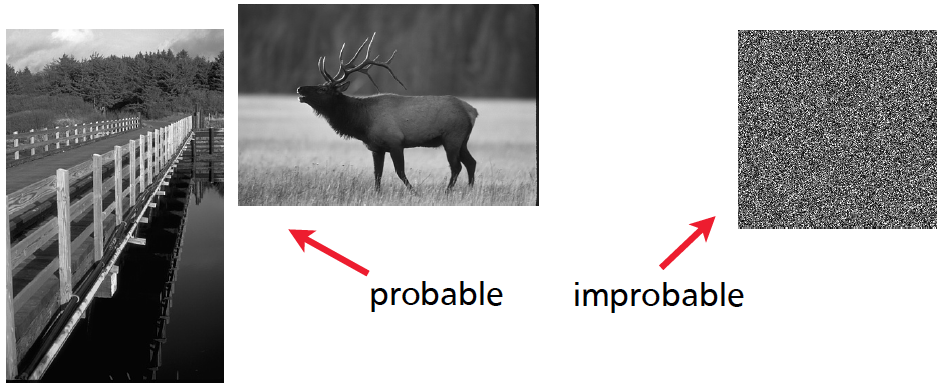
Real-world images tend to be smooth. That is, adjacent pixels tend to have similar values.




### Image denoising using MRF
Goal: Given a noisy image, recover the true (noiseless) image that is both smooth and close to the noisy image.
	
A general energy function that can meet this goal:
	
$$
		E(u) = \sum_{i\in\mathcal{V} }^{}E_{1}(u_{i}) + \sum_{i,j\in\mathcal{E} }^{}E_{2}(u_{i},v_{j})
$$
The first term represents the likelihood of the noisy and denoised image, while the second term reflects the MRF prior.

Denoising an image is equivalent to minimizing the above energy function.

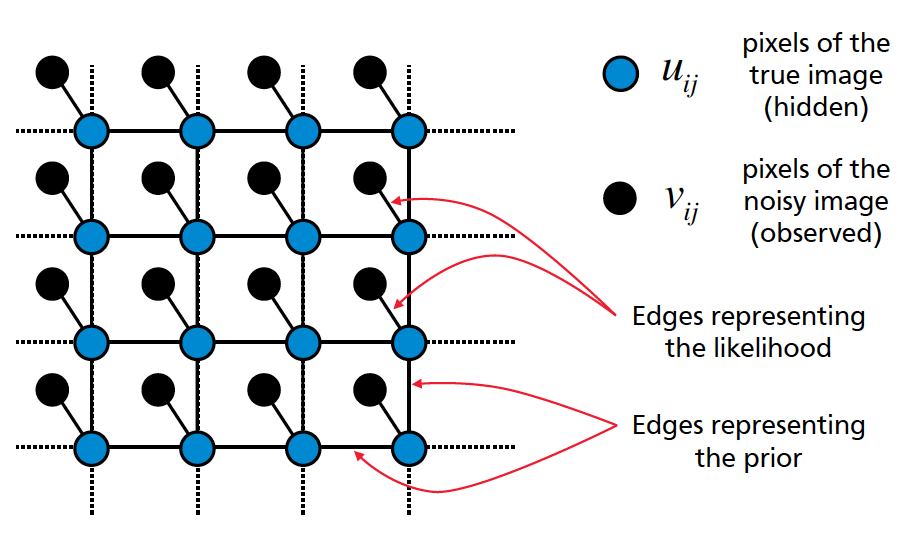

The energy/Loss function that we will use for our denoising scheme is defined as follows
$$U(x,y)=\sum_{i}{\big(\alpha (x_{i}-y_{i})^{2} + \sum_{n=1}^{4} g(x_{i}-x_{i_{n}})\big)} $$
Where $x_{i_{n}}$ are surrounding pixels of $x_{i}$ and $\alpha$ is a parameter that controls the weighting between prior and the likelihood. The first term represents the likelihood of the noisy and denoised image, while 
$g(x_{i}-x_{i_{n}})$ reflects the MRF prior. here, we assume $g(u)=|u|^{2}$.

Text(0.5, 1.0, 'True binary image')

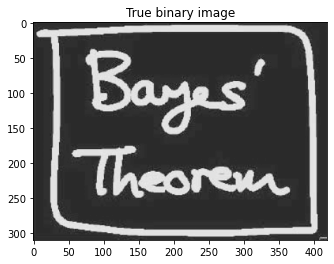

In [2]:
#load image data
to_tensor = ToTensor()
clean_img = to_tensor(Image.open('bayes.bmp'))[0]

plt.figure()
plt.imshow(clean_img,cmap='Greys')
plt.title("True binary image")

310 419


Text(0.5, 1.0, 'observed noisy image')

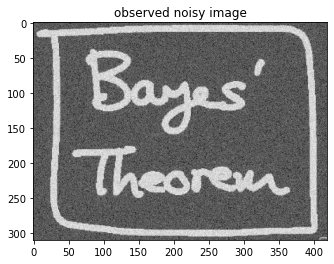

In [25]:
height,width = clean_img.shape
print(height,width)
sigma  = 0.08  #noise level
noisy_img = clean_img + torch.normal(0, sigma,size=(height, width))
plt.figure()
plt.imshow(noisy_img, cmap='Greys')
plt.title("observed noisy image")

In [26]:
def E_func(X, Y, alpha):
    loss_likelihood = ((X - Y)**2).sum()
    loss_prior = 0
    loss_prior += ((X[:, 1: ] - X[:, :-1])**2).sum()
    loss_prior += ((X[:-1, :] - X[ 1:, :])**2).sum()
    return alpha*loss_likelihood + 2*loss_prior

In [35]:
NMSE = lambda x: (((clean_img - x)**2).sum() / (clean_img**2).sum())**1
denoised_img = torch.zeros_like(noisy_img)
denoised_img.requires_grad = True
err = []
lss = []
img = []
alpha  = 5
optimizer = tAdam([denoised_img], lr = 0.001)
itr   = 1000
for i in range(itr):
    optimizer.zero_grad()
    loss = E_func(denoised_img, noisy_img, alpha)
    loss.backward()
    optimizer.step()
    err.append(NMSE(denoised_img))
    lss.append(loss.item())
    img.append(np.array(255*denoised_img.clone().detach()).astype(np.uint8))

NMSE Initial: 0.011350296437740326
NMSE Final  : 0.0332605354487896


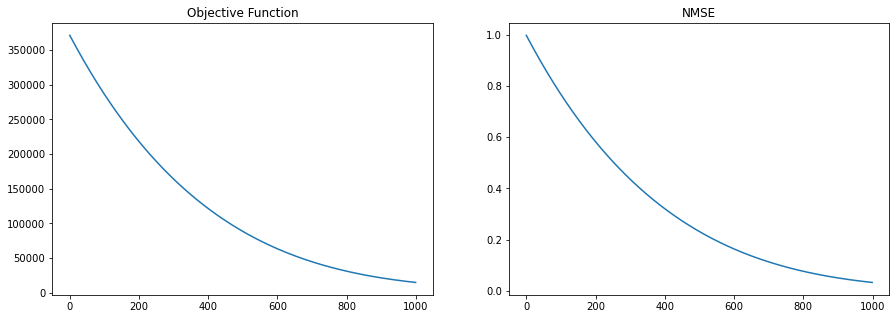

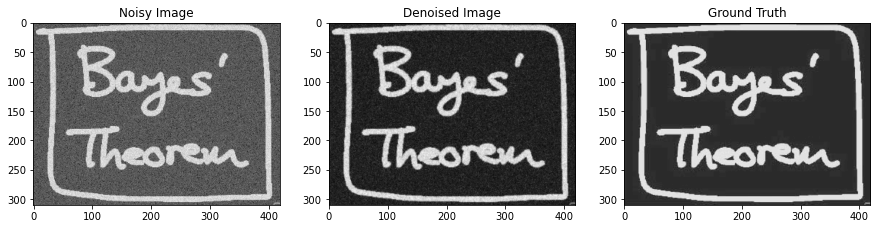

In [36]:
print("NMSE Initial: {}".format(NMSE(noisy_img)))
print("NMSE Final  : {}".format(err[-1]))
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('Objective Function')
plt.plot(lss)
plt.subplot(122)
plt.title('NMSE')
plt.plot(err)
plt.show()

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title('Noisy Image')
plt.imshow(noisy_img.detach().numpy(), cmap='Greys')
plt.subplot(132)
plt.title('Denoised Image')
plt.imshow(denoised_img.detach().numpy(), cmap='Greys')
plt.subplot(133)
plt.title('Ground Truth')
plt.imshow(clean_img.numpy(), cmap='Greys')
plt.show()